In [87]:
import numpy as np
import os
from scipy import ndarray

import skimage as sk
from skimage import transform
from skimage import util
from skimage import io
import imageio
import cv2

from numpy import linalg as LA
from scipy.sparse import csc_matrix,coo_matrix
from scipy.sparse.linalg import svds, eigs
from sklearn.decomposition import PCA,TruncatedSVD
import pickle
import pandas as pd
from random import randint
import random

import umap
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans, AffinityPropagation, MeanShift
from sklearn.preprocessing import MinMaxScaler
import kmapper as km
from kmapper.cover import Cover
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

import networkx as nx
from community import best_partition # this is not part of networkx

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.colors import ListedColormap
from scipy import ndimage
import imageio
import plotly
import plotly.graph_objs as go

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax    
def embedding(data,dim):
    projection = mapper.fit_transform(data, projection=umap.UMAP(n_components=dim, n_neighbors=200, 
                                             a=None, angular_rp_forest=False, b=None, init='spectral',
                                           learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
                                           metric_kwds=None, min_dist=0.1, n_epochs=500,
                                           negative_sample_rate=10, random_state=47,
                                           repulsion_strength=1.0, set_op_mix_ratio=0.5, spread=0.25,
                                           target_metric='categorical', target_metric_kwds=None,
                                           target_n_neighbors=-1, target_weight=0.5, transform_queue_size=10.0,
                                           transform_seed=42, verbose=False))
    return projection

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax    

def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

def rotate_image(mat, angle):
    """
    Rotates an image (angle in degrees) and expands image to avoid cropping
    """

    height, width = mat.shape[:2] # image shape has 3 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0]) 
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    return rotated_mat

import math

def round_up_to_even(f):
    return int(math.ceil(f / 2.) * 2)

In [227]:
num_rnd_cell = 200
num_rnd_img = 60

In [228]:
'''Loading the training data as a pandas dataframe'''
directories = ['/home/garner1/Work/dataset/cellImages/training_augmented/Cancer',
               '/home/garner1/Work/dataset/cellImages/training_augmented/Immuno',
              '/home/garner1/Work/dataset/cellImages/training_augmented/Other']

'''Box each nucleus'''
cell_labels = []
target_id = 0
widths = []
heights = []
target = []
for directory in directories:
    target_id += 1
    cell_id = 0
    cellList = random.sample(os.listdir(directory), k=num_rnd_cell)
    if directory == directories[0]: cellList_cancer = list(cellList)
    if directory == directories[1]: cellList_immuno = list(cellList)
    if directory == directories[2]: cellList_other = list(cellList)
    for cell in cellList:
        path = os.path.join(directory, cell)
        cell_id += 1
        imgList = random.sample(os.listdir(path), k=num_rnd_img) #sample images
        if directory == directories[0]: imgList_cancer = list(imgList)
        if directory == directories[1]: imgList_immuno = list(imgList)
        if directory == directories[2]: imgList_other = list(imgList)
        for img in imgList:
            filename = os.path.join(path, img)
            img = imageio.imread(filename)
            rmin, rmax, cmin, cmax = bbox(img)
            width = rmax-rmin
            height = cmax-cmin
            widths.append(width)
            heights.append(height)
            target.append(target_id)    
            cell_labels.append(cell_id)
        
            
'''Resizing images to small boxes'''
Mwidths = 60
Mheights = 60
images = []
for directory in directories:
    if directory == directories[0]: cellList = list(cellList_cancer)
    if directory == directories[1]: cellList = list(cellList_immuno)
    if directory == directories[2]: cellList = list(cellList_other)
    for cell in cellList:
        path = os.path.join(directory, cell)
        if directory == directories[0]: imgList = list(imgList_cancer)
        if directory == directories[1]: imgList = list(imgList_immuno)
        if directory == directories[2]: imgList = list(imgList_other)
        for img in imgList:
            filename = os.path.join(path, img)
            img = imageio.imread(filename)
            rmin, rmax, cmin, cmax = bbox(img)
            delta_w, delta_h = Mwidths-(rmax-rmin), Mheights-(cmax-cmin)
            top, bottom = delta_h//2, delta_h-(delta_h//2)
            left, right = delta_w//2, delta_w-(delta_w//2)
            newimg = np.pad(img[rmin:rmax,cmin:cmax],((left,right),(top,bottom)),'constant', constant_values=(0))
            images.append(newimg)
            
data = np.zeros((len(images),Mwidths*Mheights))
for ind in range(len(images)):
    data[ind,:] = images[ind].flatten() # from 2D arrays to 1D arrays

print(data.shape)

(36000, 3600)


In [229]:
'''2D embedding'''
n_neighbors = 30  #this parameter affects the distinguishability between clusters, the higher the better, but it costs computationally
%time embedding = umap.UMAP(n_neighbors=n_neighbors,min_dist=0.0,n_components=2,random_state=42).fit_transform(data) # do not include target together with data

CPU times: user 1min 49s, sys: 14.7 s, total: 2min 3s
Wall time: 1min 34s


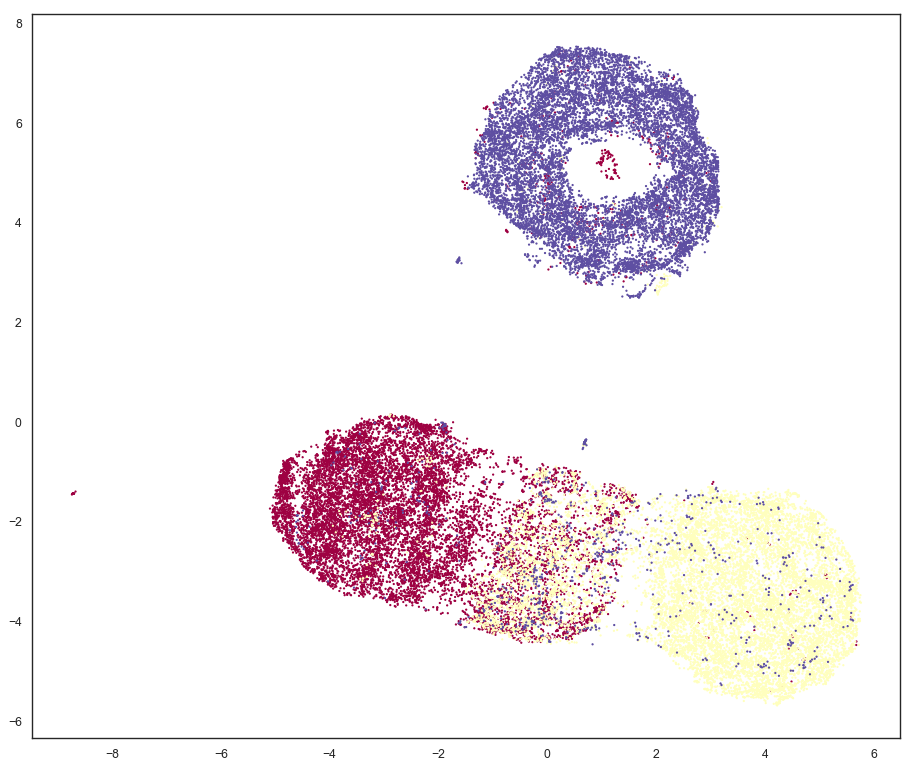

In [230]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(14, 12), dpi=80, facecolor='w', edgecolor='w',frameon=False)
plt.scatter(embedding[:, 0], embedding[:, 1], s= 1, c=target, cmap='Spectral')

In [231]:
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(embedding,target,stratify=target,random_state=42)

# Create a classifier
# classifier = svm.SVC(gamma=0.001)
classifier = KNeighborsClassifier()

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)
predicted = classifier.predict(X_test)
print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(predicted, y_test)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(predicted, y_test))

Classification report for classifier KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'):
              precision    recall  f1-score   support

           1       0.90      0.90      0.90      2991
           2       0.92      0.89      0.91      3078
           3       0.93      0.96      0.94      2931

   micro avg       0.92      0.92      0.92      9000
   macro avg       0.92      0.92      0.92      9000
weighted avg       0.92      0.92      0.92      9000


Confusion matrix:
[[2706  208   77]
 [ 203 2753  122]
 [  91   39 2801]]


In [233]:
diff_index_list = [ind for ind in range(len(y_test)) if abs(predicted[ind]-y_test[ind])>0]

List = []
for j in diff_index_list:
    [List.append(index) for index in range(len(embedding)) if all(embedding[index]-X_test[j]==0)]

row_list = [List[ind] for ind in range(len(List)) if abs(predicted[ind]-y_test[ind])>0]
data_selection = data[row_list,:]
predicted_selection = [predicted[ind] for ind in range(len(List)) if abs(predicted[ind]-y_test[ind])>0]
y_test_selection = [y_test[ind] for ind in range(len(List)) if abs(predicted[ind]-y_test[ind])>0]

CPU times: user 10.8 ms, sys: 12 ms, total: 22.8 ms
Wall time: 15.5 ms
CPU times: user 379 µs, sys: 24 µs, total: 403 µs
Wall time: 410 µs
CPU times: user 2.14 ms, sys: 138 µs, total: 2.27 ms
Wall time: 1.26 ms
CPU times: user 0 ns, sys: 1.27 ms, total: 1.27 ms
Wall time: 832 µs
CPU times: user 0 ns, sys: 1.03 ms, total: 1.03 ms
Wall time: 630 µs


2D embedding


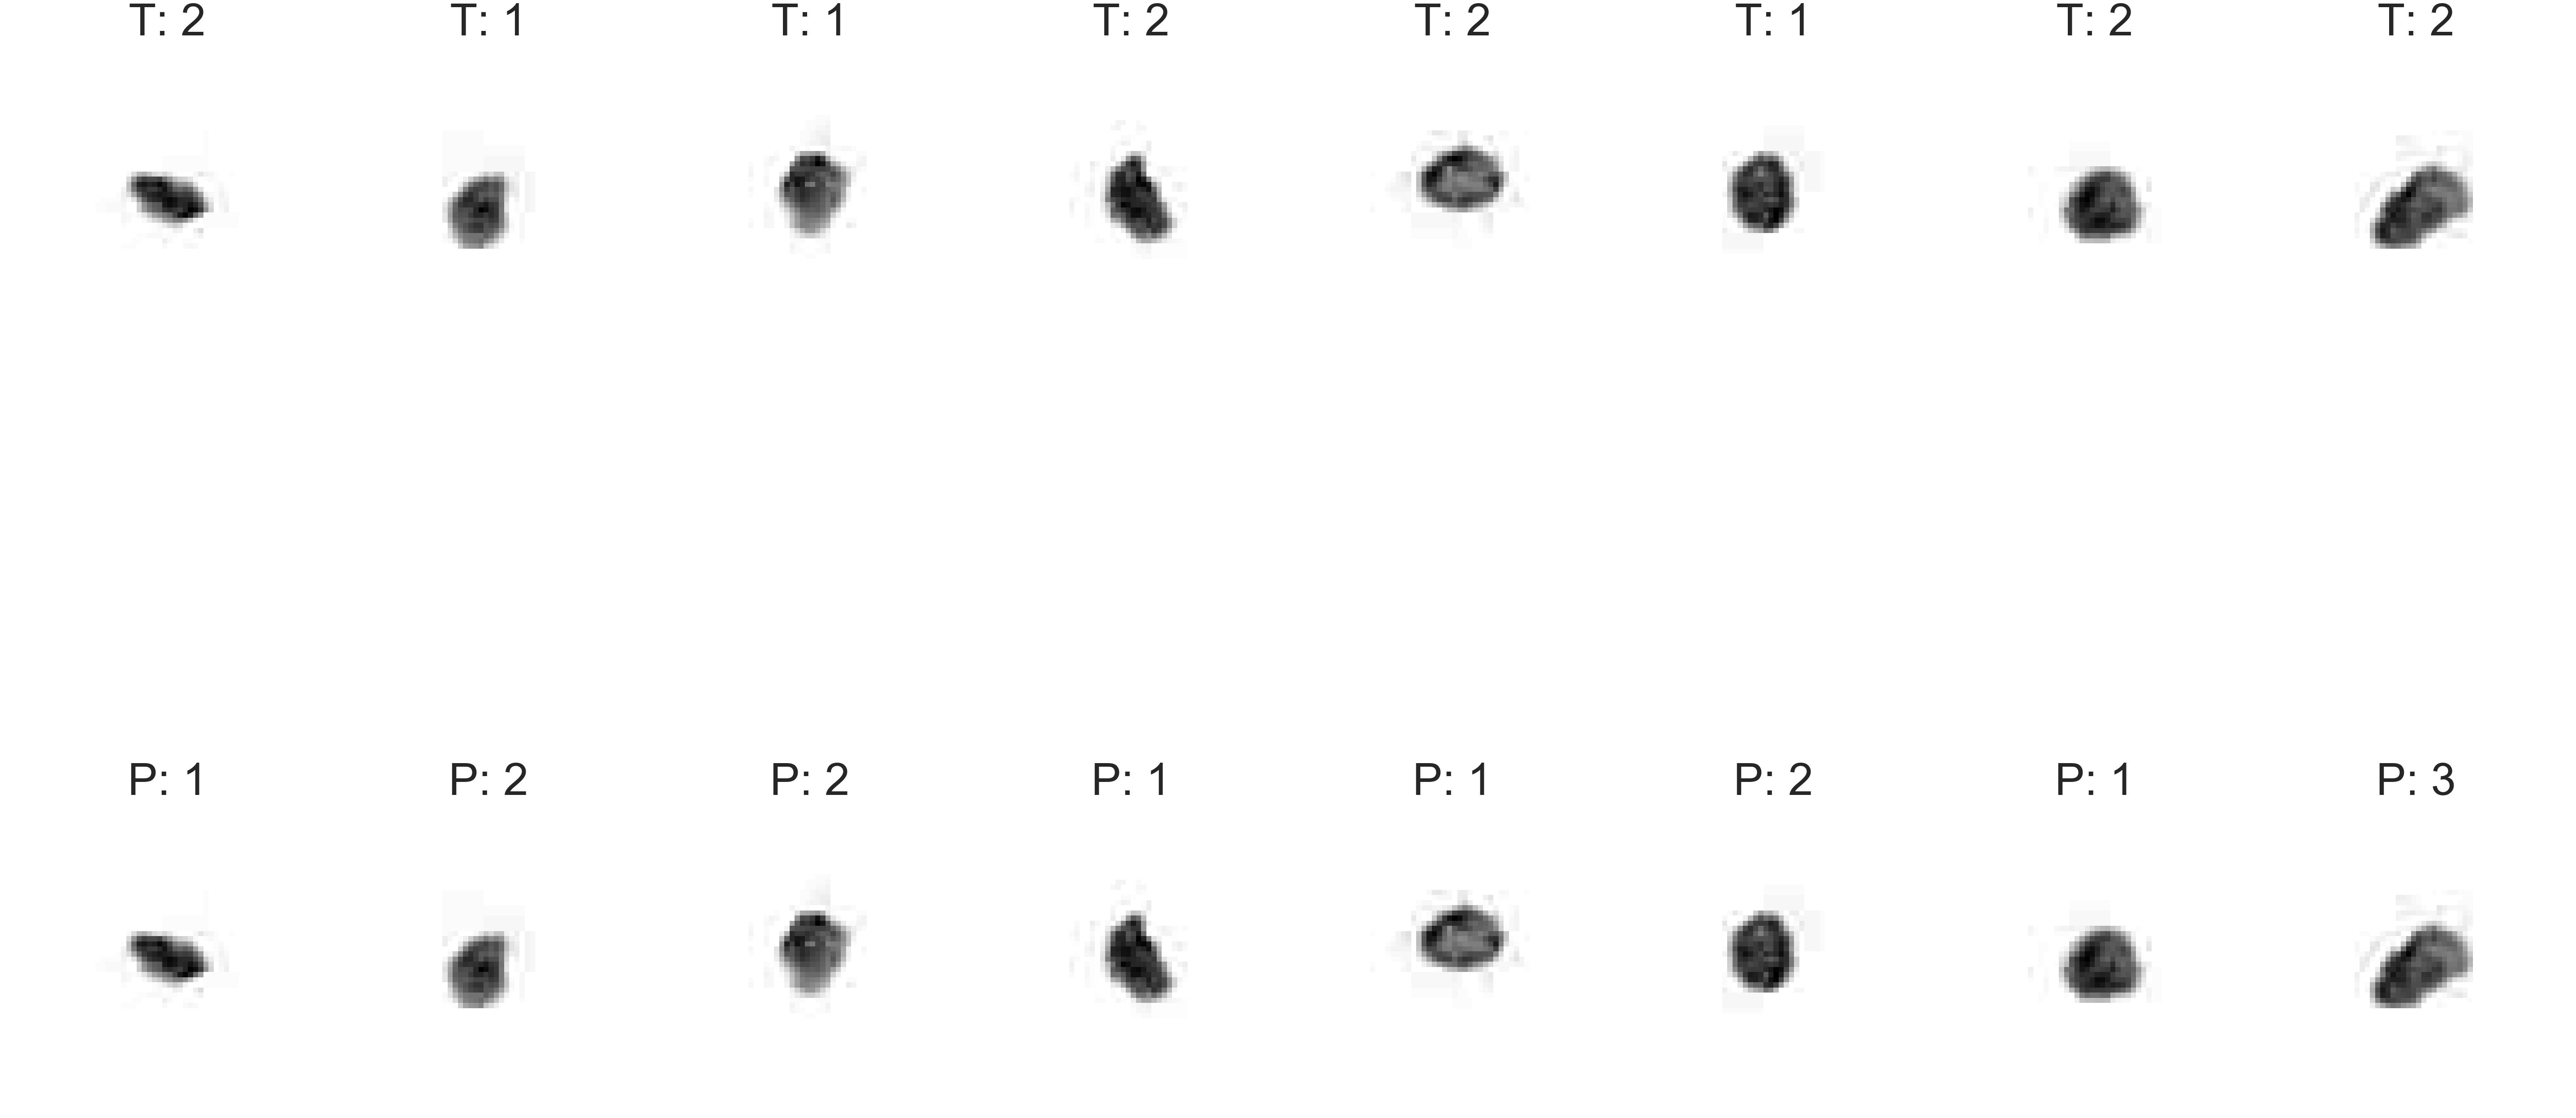

In [234]:
print(__doc__)

from sklearn import svm, metrics
from sklearn.neighbors import KNeighborsClassifier
sns.set(style='white', context='notebook', rc={'figure.figsize':(80,60)})

rnd = random.sample([ind for ind in range(len(predicted_selection))],k=8)
predicted_images = list([zip(data_selection, predicted_selection)[ind] for ind in rnd])
num_of_examples = 8
for index, (image, label) in enumerate(predicted_images[:8]):
    plt.subplot(2, num_of_examples, index + 1)
    plt.axis('off')
    plt.imshow(image.reshape((Mwidths,Mheights)), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('T: %i' % label,fontsize=100)
    

test_images_and_labels = list([zip(data_selection, y_test_selection)[ind] for ind in rnd])
for index, (image, label) in enumerate(test_images_and_labels[:8]):
    plt.subplot(2, num_of_examples, index + 1 + num_of_examples)
    plt.axis('off')
    plt.imshow(image.reshape((Mwidths,Mheights)), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('P: %i' % label,fontsize=100)

plt.setp(axes, xticks=[], yticks=[], frame_on=True)
plt.tight_layout(h_pad=0.5, w_pad=0.01)
plt.show()